# CTD data - one file per cruise

Let's first load in some libraries that we are going to use today. If you are not sure whether you have the library installed, you can embed *install.packages* within an *if* statement, like this

In [1]:
if (!requireNamespace("RNetCDF", quietly = TRUE)) {
  install.packages("RNetCDF")
}
library(RNetCDF)
if (!requireNamespace("writexl", quietly = TRUE)) {
  install.packages("writexl")
}
library(writexl)

The data are available via a THREDDS server that you can find here:
https://opendap1.nodc.no/opendap/physics/point/cruise/nansen_legacy/contents.html

If you open the link above, you can navigate to different NetCDF files, and you will be linked to OPeNDAP data access forms like this one:
https://opendap1.nodc.no:443/opendap/physics/point/cruise/nansen_legacy/NMDC_Nansen-Legacy_PR_CT_58US_2021708.nc.html

OPeNDAP makes it possible to access data over the internet without you having to download the data to your computer first. You can just remove the *html* suffix from the URL above and include it in your R script in the same way that you might include some absolute filepath to a file on your computer. 

So now let's load the data into R for one cruise.

In [2]:
url <- 'https://opendap1.nodc.no:443/opendap/physics/point/cruise/nansen_legacy/NMDC_Nansen-Legacy_PR_CT_58US_2021708.nc'
data <- open.nc(url)
print.nc(data)

netcdf classic {
dimensions:
	DEPTH = 3367 ;
	LATITUDE = 63 ;
	LONGITUDE = 63 ;
	POSITION = 63 ;
	TIME = 63 ;
	maxStrlen64 = 64 ;
variables:
	NC_DOUBLE TIME(TIME) ;
		NC_CHAR TIME:long_name = "Time" ;
		NC_CHAR TIME:standard_name = "time" ;
		NC_CHAR TIME:units = "days since 1950-01-01T00:00:00Z" ;
		NC_DOUBLE TIME:valid_min = -90000 ;
		NC_DOUBLE TIME:valid_max = 90000 ;
		NC_CHAR TIME:axis = "T" ;
		NC_INT TIME:QC_indicator = 1 ;
		NC_CHAR TIME:uncertainty = " " ;
		NC_CHAR TIME:comment = " " ;
		NC_CHAR TIME:ancillary_variables = "TIME_QC" ;
		NC_CHAR TIME:calendar = "standard" ;
	NC_FLOAT LATITUDE(LATITUDE) ;
		NC_CHAR LATITUDE:axis = "Y" ;
		NC_INT LATITUDE:QC_indicator = 1 ;
		NC_CHAR LATITUDE:uncertainty = " " ;
		NC_CHAR LATITUDE:comment = " " ;
		NC_CHAR LATITUDE:ancillary_variables = "POSITION_QC" ;
		NC_CHAR LATITUDE:standard_name = "latitude" ;
		NC_CHAR LATITUDE:long_name = "Latitude of each location" ;
		NC_CHAR LATITUDE:units = "degree_north" ;
		NC_DOUBLE LATITUDE:valid

At a glance, we can see it has 5 dimensions; they they show that there are data from 63 different locations. There are 3367 points of depth. This doesn't mean that there are 3367 samples for every station; more likely there is a lot of 'empty' space in this file where a measurement was not taken at a certain depth. This is necessary for us to use a single depth dimension for a range of different depth profiles, which each sample different depths.

There is then a whole host of variables and attributes which correspond. The coordinate variables are first, with the same name as their respective dimension. For example TIME(TIME) is the VARIABLE(DIMENSION). The dimension states how many times have been sampled, the variable states what these times are.

There is no coordinate variable for depth. Therefore, we can't be certain what depths have been sampled. However, we can see from the 'geospatial_vertical_min' global attribute that the minimum depth sampled was 5 m, and from 'geospatial_vertical_max' that the maximum depth sampled was 3367 m. Since there are 3367 depth points, we can assume that there is a 1 m sampling increment between these depths. The pressure variable might also be able to help us if we are uncertain.

Most of the variables have two dimensions; depth and time. Latitude and longitude are only used in coordinate variables, but we can assume here that each coordinate corresponds to a single time. There are other ways to create a netcdf file to more explicitly state this, by having longitude and latitude variables that each have the dimension of time, thus linking them together. An important point to take away is that different people have different ways of doing things, but we should be able to easily understand what has been done and adapt our code accordingly.

Let's write the data that we are interested in to variables we can easily use later. Some of the variables have a variable attribute 'scale_factor'. This means that the values have been scaled by this factor before storing the values. This is done to save space. For example, let's look at the temperature variable. 

In [3]:
var.get.nc(data, "TEMP")[1:50] # Just the first 50 values
att.get.nc(data, "TEMP", "scale_factor")

[1] 3226 3211 3202 3205 3213 3215 3210 3215 3191 3162 3144 3118 3081 2993 2913
[16] 2861 2837 2826 2809 2776 2743 2703 2687 2652 2587 2544 2508 2483 2472 2434
[31] 2399 2355 2298 2277 2252 2225 2201 2173 2113 2073 2060 2040 2022 2006 2004
[46] 2008 2067 2126 2145 2143

[1] 0.001

These values are far too high. They have been divided by 0.001 before they have been stored. So we need to multiply by 0.001 to correct for this. Some softwares will do this for us automatically (e.g. xarray in Python) but RNetCDF does not.

In [14]:
time <- var.get.nc(data, "TIME")
latitude <- var.get.nc(data, "LATITUDE")
longitude <- var.get.nc(data, "LONGITUDE")
pressure <- var.get.nc(data, "PRES")
psal <- var.get.nc(data, "PSAL") * att.get.nc(data, "PSAL", "scale_factor")
temp <- var.get.nc(data, "TEMP") * att.get.nc(data, "TEMP", "scale_factor")

Our time variable is currently in 'days since 1950-01-01T00:00:00Z' Let's convert these values to timestamps that are more useful to us. Again, some other softwares will do this for us.

In [5]:
att.get.nc(data, "TIME", "units")
date0 <- strptime("01/01/1950 00:00:00", "%m/%d/%Y %H:%M:%S", tz="UTC")
timestamps <- date0 + (3600 * 24 * time)
timestamps

[1] "days since 1950-01-01T00:00:00Z"

 [1] "2021-07-12 19:05:04 UTC" "2021-07-14 08:14:43 UTC"
 [3] "2021-07-14 11:15:08 UTC" "2021-07-14 19:56:03 UTC"
 [5] "2021-07-14 23:59:51 UTC" "2021-07-15 02:01:30 UTC"
 [7] "2021-07-15 03:35:31 UTC" "2021-07-15 04:45:26 UTC"
 [9] "2021-07-15 05:55:33 UTC" "2021-07-15 07:25:12 UTC"
[11] "2021-07-15 08:44:11 UTC" "2021-07-15 12:31:06 UTC"
[13] "2021-07-15 17:10:07 UTC" "2021-07-16 07:17:43 UTC"
[15] "2021-07-16 10:32:26 UTC" "2021-07-16 17:22:03 UTC"
[17] "2021-07-16 20:34:01 UTC" "2021-07-16 21:18:06 UTC"
[19] "2021-07-16 22:07:07 UTC" "2021-07-16 23:09:27 UTC"
[21] "2021-07-16 23:56:54 UTC" "2021-07-17 01:30:20 UTC"
[23] "2021-07-17 06:00:16 UTC" "2021-07-17 10:37:39 UTC"
[25] "2021-07-17 11:38:07 UTC" "2021-07-17 12:46:16 UTC"
[27] "2021-07-17 15:14:44 UTC" "2021-07-17 16:43:03 UTC"
[29] "2021-07-17 18:32:21 UTC" "2021-07-17 22:19:12 UTC"
[31] "2021-07-18 00:28:46 UTC" "2021-07-18 02:17:32 UTC"
[33] "2021-07-18 04:17:28 UTC" "2021-07-18 08:52:44 UTC"
[35] "2021-07-18 10:43:45 UTC" 

The file doesn't explicitly tell us, but we will assume that each of our 63 coordinates relates to a single one of our 63 times. Before we output these data to Excel, we can first combine them into a dataframe (basically a table).

There are a number of different ways to do this depending on how we want to structure our data. Here, we will create one file for each depth profile. Each file will have multiple columns; time, latitude, longitude, pressure, salinity and temperature.


In [6]:
for (profile in 1:length(time)) {
    
    # Isolating the values for each profile
    # 2D variables
    psal_profile <- psal[,profile]
    temp_profile <- temp[,profile]
    pressure_profile <- pressure[,profile]
    # 1D variables
    time <- timestamps[profile]
    lat <- latitude[profile]
    lon <- longitude[profile]
    
    df_profile <- data.frame(
        Time = time, 
        Latitude = lat,
        Longitude = lon,
        Pressure = pressure_profile, 
        Temperature = temp_profile, 
        PracticalSalinity = psal_profile
    )
    
    output_filepath_profile <- paste("../data/ctd_data_profile_",profile,".xlsx", sep="")
    #write_xlsx(df_profile, output_filepath_profile)
}

## Accessing data for one cast

### Based on latitude/longitude



In [16]:
latitude <- var.get.nc(data, "LATITUDE")
latitude

[1] 78.1282 76.0000 75.9998 76.0000 76.4998 76.5958 76.6930 76.7645 76.8122
[10] 76.9147 77.0002 77.5000 77.4998 77.5017 77.5000 78.0000 78.4000 78.4505
[19] 78.4993 78.5460 78.5935 78.7500 78.7500 78.7500 78.7498 78.7498 78.8767
[28] 79.0000 79.1170 79.2483 79.3758 79.5007 79.6252 79.7500 79.7500 79.7498
[37] 79.7998 79.9003 79.9998 80.5015 80.4987 80.5028 80.5122 80.4800 80.7325
[46] 81.0013 81.3123 81.3792 81.4105 81.4317 81.4567 81.5027 81.5478 81.5467
[55] 81.5425 81.5427 81.5872 81.6205 81.6787 82.0010 81.9817 82.0038 82.0220

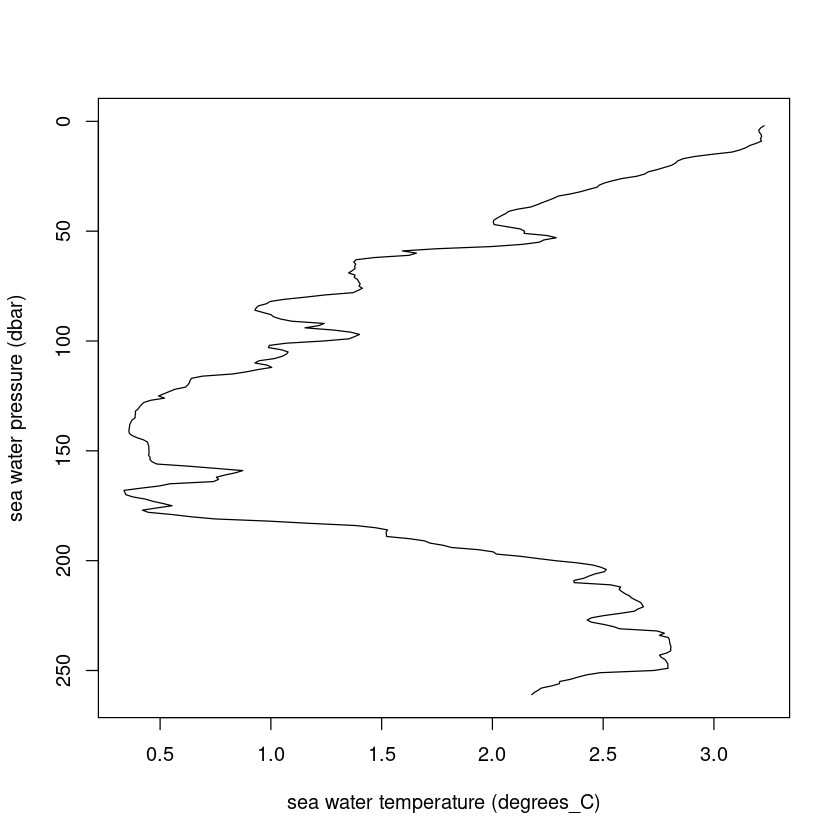

In [17]:
desired_latitude <- 78.8767013549805
# Finding index of the value
latitude_index <- which(latitude == desired_latitude)

# Extract values just for that latitude
temperature <- var.get.nc(data, "TEMP", start=c(NA, latitude_index), count=c(NA, 1)) * att.get.nc(data, "TEMP", "scale_factor")
# Get the associated pressure values
pres <- var.get.nc(data, "PRES", start=c(NA, latitude_index), count=c(NA, 1))

plot(
    temperature,
    pres,
    type='l',
    ylim=c(max(pres, na.rm = TRUE),0),
    ylab='sea water pressure (dbar)',
    xlab= 'sea water temperature (degrees_C)'
    
)

### Based on time

In [7]:
att.get.nc(data,"TIME","units")

[1] "days since 1950-01-01T00:00:00Z"

In [8]:
days_since_1950 <- var.get.nc(data,"TIME")
days_since_1950

[1] 26125.80 26127.34 26127.47 26127.83 26128.00 26128.08 26128.15 26128.20
 [9] 26128.25 26128.31 26128.36 26128.52 26128.72 26129.30 26129.44 26129.72
[17] 26129.86 26129.89 26129.92 26129.96 26130.00 26130.06 26130.25 26130.44
[25] 26130.48 26130.53 26130.64 26130.70 26130.77 26130.93 26131.02 26131.10
[33] 26131.18 26131.37 26131.45 26131.55 26131.84 26131.89 26131.94 26132.29
[41] 26132.44 26132.54 26132.60 26133.58 26133.83 26134.12 26134.41 26134.49
[49] 26134.53 26134.56 26134.59 26134.66 26134.73 26135.58 26136.26 26136.39
[57] 26136.47 26136.57 26136.71 26137.04 26137.61 26138.13 26138.39

Let's convert these to timestamps so we can see what times are in our dataset.

In [10]:
# Define the origin date
origin_date <- as.POSIXct("1950-01-01 00:00:00", tz = "UTC")

# Convert days to seconds
seconds_since_1950 <- days_since_1950 * 24 * 60 * 60

# Convert to timestamps
timestamps <- origin_date + seconds_since_1950
timestamps

 [1] "2021-07-12 19:05:04 UTC" "2021-07-14 08:14:43 UTC"
 [3] "2021-07-14 11:15:08 UTC" "2021-07-14 19:56:03 UTC"
 [5] "2021-07-14 23:59:51 UTC" "2021-07-15 02:01:29 UTC"
 [7] "2021-07-15 03:35:31 UTC" "2021-07-15 04:45:26 UTC"
 [9] "2021-07-15 05:55:33 UTC" "2021-07-15 07:25:11 UTC"
[11] "2021-07-15 08:44:11 UTC" "2021-07-15 12:31:06 UTC"
[13] "2021-07-15 17:10:07 UTC" "2021-07-16 07:17:43 UTC"
[15] "2021-07-16 10:32:26 UTC" "2021-07-16 17:22:03 UTC"
[17] "2021-07-16 20:34:01 UTC" "2021-07-16 21:18:06 UTC"
[19] "2021-07-16 22:07:07 UTC" "2021-07-16 23:09:26 UTC"
[21] "2021-07-16 23:56:53 UTC" "2021-07-17 01:30:20 UTC"
[23] "2021-07-17 06:00:16 UTC" "2021-07-17 10:37:39 UTC"
[25] "2021-07-17 11:38:06 UTC" "2021-07-17 12:46:16 UTC"
[27] "2021-07-17 15:14:44 UTC" "2021-07-17 16:43:03 UTC"
[29] "2021-07-17 18:32:20 UTC" "2021-07-17 22:19:12 UTC"
[31] "2021-07-18 00:28:46 UTC" "2021-07-18 02:17:32 UTC"
[33] "2021-07-18 04:17:27 UTC" "2021-07-18 08:52:44 UTC"
[35] "2021-07-18 10:43:45 UTC" 

So we need to time series (above), work out what index in the time series our desired date corresponds to, and then select from the data variable based on that index.

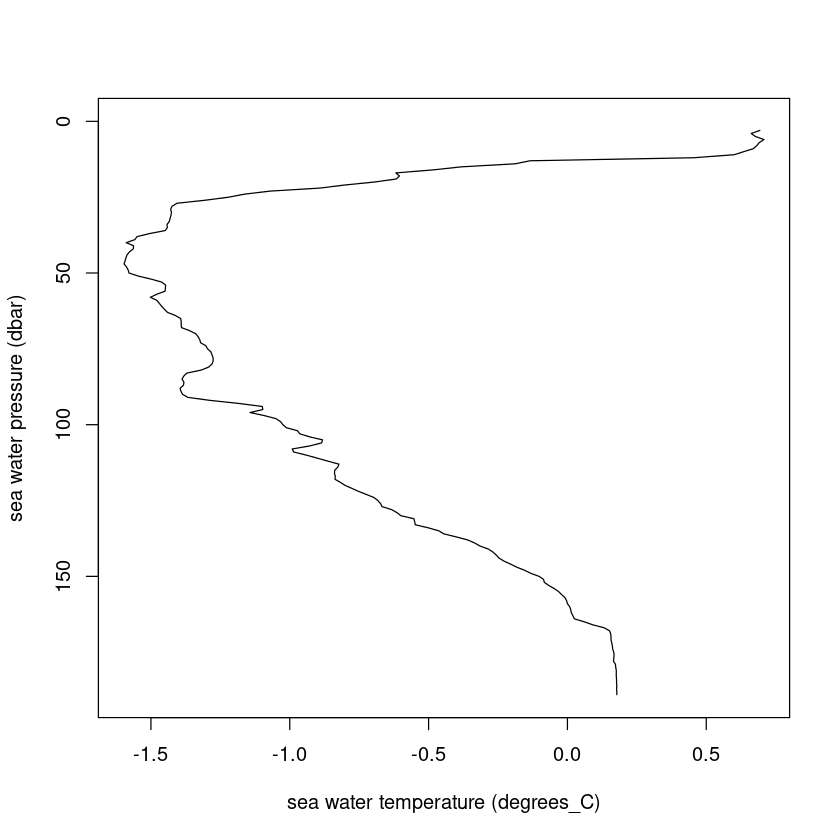

In [15]:
desired_time <- as.POSIXct("2021-07-16 17:22:03", tz = "UTC")

# Finding the index of that value
time_index <- which(timestamps == desired_time)

# Extract values just for that time
temperature <- var.get.nc(data, "TEMP", start=c(NA, time_index), count=c(NA, 1)) * att.get.nc(data, "TEMP", "scale_factor")
# Get the associated pressure values
pres <- var.get.nc(data, "PRES", start=c(NA, time_index), count=c(NA, 1))

plot(
    temperature,
    pres,
    type='l',
    ylim=c(max(pres, na.rm = TRUE),0),
    ylab='sea water pressure (dbar)',
    xlab= 'sea water temperature (degrees_C)'
    
)

## Citing the data

Please cite the data for the cruise or cruises you have used the data from.

For the data used in this notebook, the citation is:

*Elisabeth Jones (2022) CTD data from Nansen Legacy Cruise - Joint cruise 2-1 https://doi.org/10.21335/NMDC-2085836005*

## Citing this tutorial

If you find this tutorial series useful for your work, consider citing the repository:

Luke Marsden. (2024, May 24). Accessing Nansen Legacy data in R. Zenodo. https://doi.org/10.5281/zenodo.11277693

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.11277693.svg)](https://doi.org/10.5281/zenodo.11277693)